In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
import IPython
import IPython.display
import matplotlib as mpl
import seaborn as sns
from matplotlib.patches import Patch
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
path = "/Users/eliassovikgunnarsson/Downloads/vix-daily_csv.csv"
df = pd.read_csv(path, header = 0, index_col= 0)
df.head()

,VIX Open,VIX High,VIX Low,VIX Close
Date,,,,
2004-01-02,17.96,18.68,17.54,18.22
2004-01-05,18.45,18.49,17.44,17.49
2004-01-06,17.66,17.67,16.19,16.73
2004-01-07,16.72,16.75,15.50,15.50
2004-01-08,15.42,15.68,15.32,15.61


<AxesSubplot: xlabel='Date'>

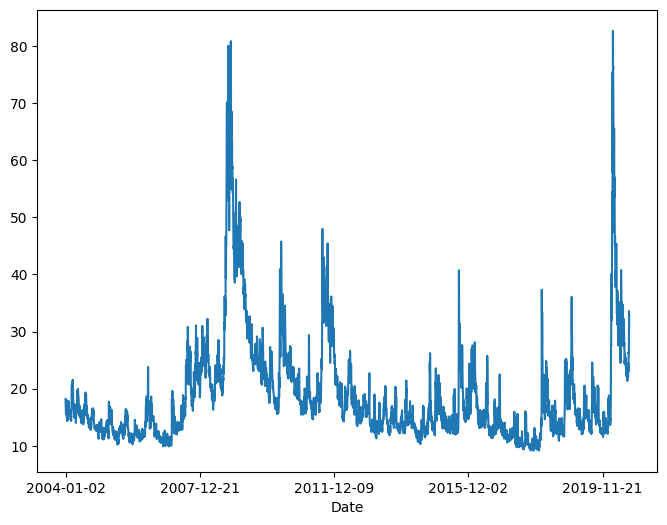

In [2]:
df['VIX Close'].plot()

#### References
* [How To Backtest Machine Learning Models for Time Series Forecasting](https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/)
* [Omphalos, Uber’s Parallel and Language-Extensible Time Series Backtesting Tool](https://www.uber.com/en-NO/blog/omphalos/)
* [Walk-Forward Analysis Demonstration with backtrader](https://ntguardian.wordpress.com/2017/06/19/walk-forward-analysis-demonstration-backtrader/)

In applied machine learning, we often split our data into a train and test set: the training set used to prepare the model and the test set used to evaluate it. We may evven use k-fold cross validation that repeats this process by systematically splitting the data into k groups, each given a chance to be a held out model. **These models cannot be directly udes twith time series data.** This is because they assume that there is no relationship between the observations, that each observation is independent.

### Walk Forward Validation
In practice, we very likely will retrain our model as new data becomes available. This would give the model the best opportunity to make good forecasts at each time steps. We can evaluate our machine learning models under this assumption. This procedure applies two types of backtesting: sliding window and expanding window. While both have their applicable use cases, the sliding window work achieves favorable balance between model accuracy and training time [especially when it comes to testing high frequency data such as daily and hourly time series.](https://www.uber.com/en-NO/blog/omphalos/) The expanding wondow form, on the other hand is used more often in weekly, monthly or quarterly time series where the number of historical pointa are limited.

##### Sliding window
The sliding window method requires three hyperparameters: training window size, forecasting window size (horizon), and sliding steps:
* Training window size: The number of data points included in a training pass
* Forecasting window size: the number of data points to include in forecasting
* Sliding steps: the number of data points skipped from one pass to another

![image info](images/sliding_window.png)

The build in TimeSeriesSplit from sklearn.model_selection is limited to an expanding window

In [3]:
from sklearn.model_selection import TimeSeriesSplit
X = df['VIX Close']
cv = TimeSeriesSplit(n_splits=5, gap=200)

[Visualizing cross-validation behavior](https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html)

In [4]:
import tscv_sliding
rng = np.random.RandomState(1338)
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
n_splits = 5

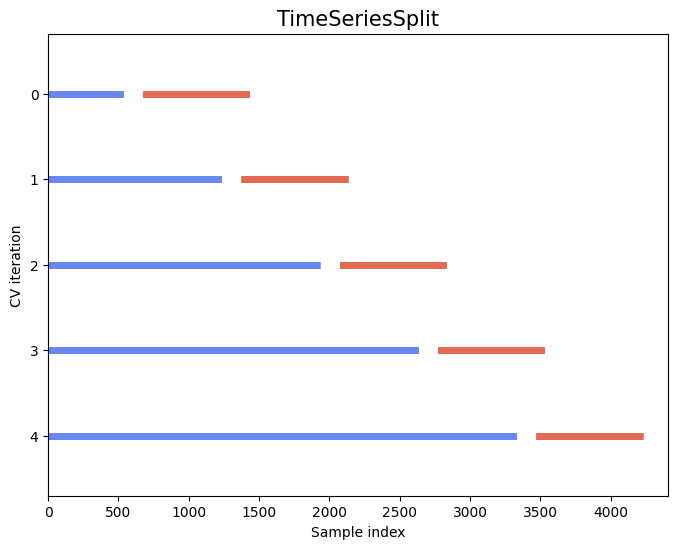

In [5]:
fig, ax = plt.subplots()
tscv_sliding.plot_cv_indices(cv, X, ax, n_splits)
plt.show()

The build in TimeSeriesSplit class from sklearn.model_selection can be modified to a sliding window

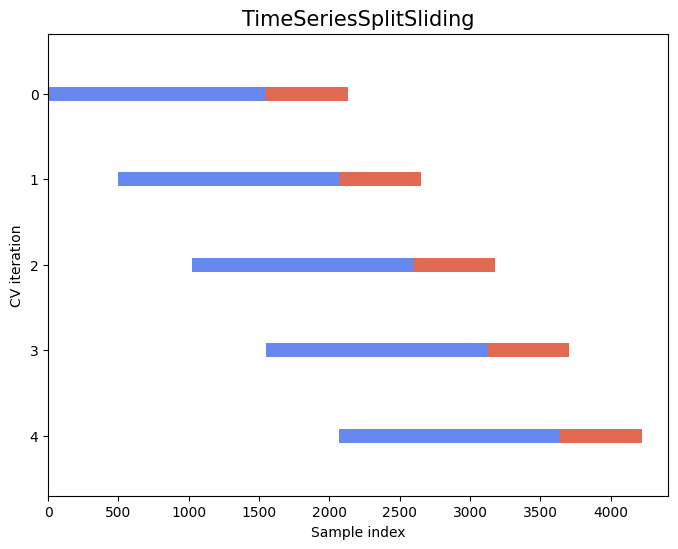

In [6]:
tscv = tscv_sliding.TimeSeriesSplitSliding(n_splits=n_splits, train_splits=3, test_splits = 1, fixed_length=True)
fig, ax = plt.subplots()
tscv_sliding.plot_cv_indices(tscv, X, ax)
plt.show()

### Standardization using EWMA

In [7]:
def ewma_standardize_df(df, alpha=0.94):
    """
    Standardizes each column of a DataFrame using EWMA.

    Parameters:
    df (pd.DataFrame): The DataFrame to be standardized.
    alpha (float): The smoothing parameter for EWMA. Default is 0.94.

    Returns:
    pd.DataFrame: The standardized DataFrame.
    """

    # Calculate EWMA and standard deviation of EWMA for each column
    ewma = df.ewm(alpha=alpha, adjust=False)
    std_dev = ewma.std()

    # Standardize each column of the DataFrame
    mean_ewma = ewma.mean()
    standardized = (df - mean_ewma) / std_dev
    standardized.columns = df.columns

    return standardized.iloc[1:]

def reverse_ewma_standardize_df(standardized_df, original_df, alpha=0.94):
    """
    Reverses the EWMA standardization applied by the ewma_standardize_df() function.

    Parameters:
    standardized_df (pd.DataFrame): The standardized DataFrame to be reversed.
    original_df (pd.DataFrame): The original DataFrame used to create the standardized DataFrame.
    alpha (float): The smoothing parameter for EWMA. Default is 0.94.

    Returns:
    pd.DataFrame: The unstandardized DataFrame.
    """

    # Calculate EWMA and standard deviation of EWMA for each column of the original DataFrame
    ewma = original_df.ewm(alpha=alpha, adjust=False).mean()
    std_dev = ewma.diff().std()
    

    # Unstandardize each column of the standardized DataFrame
    mean_ewma = ewma.mean()
    unstandardized = standardized_df * std_dev + mean_ewma
    unstandardized.columns = standardized_df.columns

    return unstandardized


In [8]:
#df = ewma_standardize_df(df)
df.head()

,VIX Open,VIX High,VIX Low,VIX Close
Date,,,,
2004-01-02,17.96,18.68,17.54,18.22
2004-01-05,18.45,18.49,17.44,17.49
2004-01-06,17.66,17.67,16.19,16.73
2004-01-07,16.72,16.75,15.50,15.50
2004-01-08,15.42,15.68,15.32,15.61


In [9]:
from sklearn.preprocessing import StandardScaler
#cols = df.columns
#scale = StandardScaler()
#df = pd.DataFrame(scale.fit_transform(df), columns=cols)
#df


<AxesSubplot: xlabel='Date'>

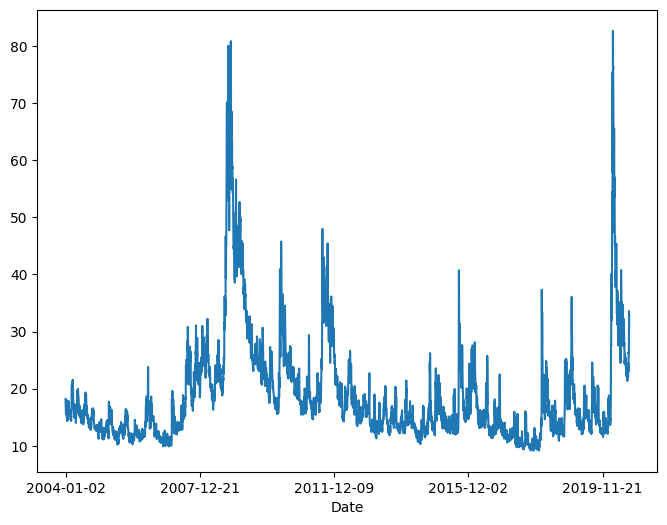

In [10]:
df['VIX Close'].plot()

In [11]:
#df['VIX Close'].iloc[:100].plot()

### Data Windowing

In [12]:
from window_generator import WindowGenerator
df.columns

Index(['VIX Open', 'VIX High', 'VIX Low', 'VIX Close'], dtype='object')

In [13]:
df = df.drop(['VIX Open', 'VIX High', 'VIX Low'], axis = 1)
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]
df.head()

,VIX Close
Date,
2004-01-02,18.22
2004-01-05,17.49
2004-01-06,16.73
2004-01-07,15.50
2004-01-08,15.61


In [14]:
w1 = WindowGenerator(input_width=30, label_width=1, shift=1, label_columns=['VIX Close'], train_df=train_df, val_df=val_df, test_df=test_df)
w1

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30]
Label column name(s): ['VIX Close']

In [15]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(df[:w1.total_window_size]),
                           np.array(df[100:100+w1.total_window_size]),
                           np.array(df[200:200+w1.total_window_size])])

example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

All shapes are: (batch, time, features)
Window shape: (3, 31, 1)
Inputs shape: (3, 30, 1)
Labels shape: (3, 1, 1)


2023-03-28 14:26:38.623964: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-28 14:26:38.624055: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [16]:
samples = w1.make_dataset(df)
samples.element_spec

(TensorSpec(shape=(None, 30, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [17]:
for example_inputs, example_labels in w1.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

2023-03-28 14:26:38.816640: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Inputs shape (batch, time, features): (32, 30, 1)
Labels shape (batch, time, features): (32, 1, 1)


In [18]:
for train, val in w1.folds:
    x = np.concatenate([x for x, y in train.take(1)], axis=0)
    print(x)

[[[-1.1630954e+00]
  [-1.0219676e+00]
  [-6.6473794e-01]
  [-6.9560963e-01]
  [-3.3837995e-01]
  [-4.4422579e-01]
  [-6.1181504e-01]
  [-5.2361017e-01]
  [-1.0440189e+00]
  [-1.0793008e+00]
  [-9.3817300e-01]
  [-9.6022421e-01]
  [-8.8966036e-01]
  [-8.8966036e-01]
  [-8.8525009e-01]
  [-8.4996814e-01]
  [-9.6022421e-01]
  [-5.4125112e-01]
  [-7.8381449e-01]
  [-7.8381449e-01]
  [-8.4114766e-01]
  [-9.4699347e-01]
  [-7.7940428e-01]
  [-7.8381449e-01]
  [-8.7642962e-01]
  [-5.6330234e-01]
  [ 1.8643899e-01]
  [-8.6996086e-02]
  [-1.8402143e-01]
  [ 1.0993593e+00]]

 [[-1.2821720e+00]
  [-1.2468901e+00]
  [-1.1322237e+00]
  [-1.1189929e+00]
  [-8.1909645e-01]
  [-6.6914821e-01]
  [-7.8822476e-01]
  [ 3.4961799e-01]
  [ 7.1772665e-02]
  [-2.0166241e-01]
  [-3.9571309e-01]
  [-5.9417403e-01]
  [-7.9263496e-01]
  [-6.0740477e-01]
  [-3.6043116e-01]
  [-6.2063551e-01]
  [-2.3694435e-01]
  [-3.5602093e-01]
  [-3.2073897e-01]
  [-7.8175597e-02]
  [-4.1335407e-01]
  [-2.8545702e-01]
  [-3.9571

In [19]:
MAX_EPOCHS = 500

negloglik = lambda y, rv_y: -rv_y.log_prob(y)


def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val)
                      #callbacks=[early_stopping])
  return history

In [20]:
n_samples = np.concatenate([x for x, y in w1.train], axis=0).shape[0]

In [21]:
import tensorflow_probability as tfp
tfd = tfp.distributions

# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  c = np.log(np.expm1(1.))
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1)),
  ])

# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t, scale=1),
          reinterpreted_batch_ndims=1)),
  ])

In [22]:
lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dropout(rate = 0.2),
    tf.keras.layers.LSTM(64, return_sequences=False),
    tf.keras.layers.Dropout(rate = 0.2),
    tfp.layers.DenseVariational(32, posterior_mean_field, prior_trainable, kl_weight=1/n_samples),
    tfp.layers.DenseVariational(32, posterior_mean_field, prior_trainable, kl_weight=1/n_samples),
    tfp.layers.DenseVariational(1, posterior_mean_field, prior_trainable, kl_weight=1/n_samples),
])

history = compile_and_fit(lstm_model, w1)

val_performance = {}
performance = {}

val_performance['LSTM'] = lstm_model.evaluate(w1.val)
performance['LSTM'] = lstm_model.evaluate(w1.test, verbose=0)

Epoch 1/500


2023-03-28 14:26:41.708030: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-28 14:26:42.082240: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-28 14:26:42.283647: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-28 14:26:42.589206: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-28 14:26:42.814103: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


KeyboardInterrupt: 

In [ ]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            16896     
                                                                 
 dropout (Dropout)           (None, 30, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_variational (DenseVar  (None, 32)               6240      
 iational)                                                       
                                                                 
 dense_variational_1 (DenseV  (None, 32)               3168      
 ariational)                                            

In [ ]:
#predictions
#predictions = predictions[:,-1]

In [ ]:
val = np.concatenate([x for x, y in w1.val], axis=0)

predictions = []
for i in range(100):
    predictions.append(lstm_model(val))

predictions = np.array(predictions).reshape((100,-1))
y = np.concatenate([y for x, y in w1.val], axis=0)

mean = np.mean(predictions, axis = 0)
std = np.std(predictions, axis = 0)


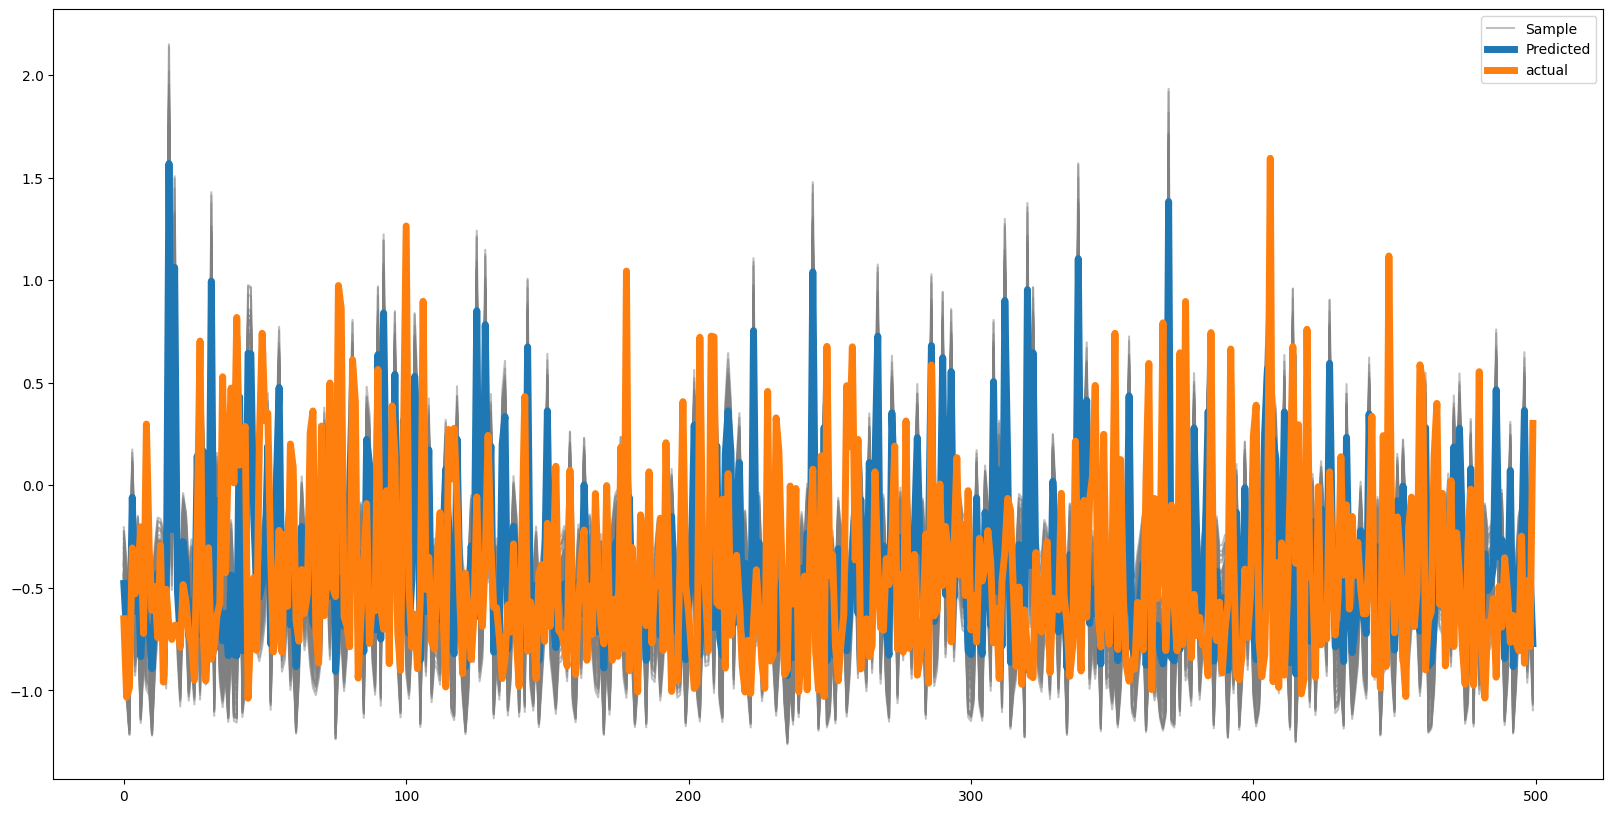

In [ ]:
predicted = mean.flatten()
actual = y.flatten()

timesteps = np.array([i for  i in range(len(predicted))])

n = 500

fig, ax = plt.subplots(figsize=(20,10))
for i, pred in enumerate(predictions[:100]):
    label = "Sample" if i == 0 else None
    sns.lineplot(ax = ax, x = timesteps[0:n], y = pred[0:n], label = label, color = 'gray', alpha=0.5)
sns.lineplot(ax = ax, x = timesteps[0:n], y = predicted[0:n], label = 'Predicted', linewidth = 5)
sns.lineplot(ax = ax, x = timesteps[0:n], y = actual[0:n], label = 'actual', linewidth = 5)
ax.legend()
plt.show()

In [ ]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            16896     
                                                                 
 dropout (Dropout)           (None, 30, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_variational (DenseVar  (None, 32)               6240      
 iational)                                                       
                                                                 
 dense_variational_1 (DenseV  (None, 32)               3168      
 ariational)                                            

To perform MCMC inference in TensorFlow for a Bayesian LSTM model, you can use the tfp.mcmc module of TensorFlow Probability (TFP). Here are the general steps you can follow:

Define the Bayesian LSTM model using tf.keras.layers and wrap the layers with appropriate TFP distributions. For example, you can use tfp.layers.DenseVariational to create a Bayesian dense layer, and tfp.layers.LSTMCellVariational to create a Bayesian LSTM cell.
Define the likelihood function for your model. This function should take the model's output and the target variable as input and return the log-likelihood of the target variable given the model's output.
Define the prior distribution for the model's parameters using TFP distributions. You can use the tfp.distributions.Normal distribution to specify a Gaussian prior.
Define the joint log-probability function for the model. This function should take the model's parameters and the data as input and return the log-joint probability of the model's parameters and the data.
Define the number of MCMC samples to draw, the burn-in period, and the thinning factor. These hyperparameters control the behavior of the MCMC sampler.
Initialize the model's parameters randomly and run the MCMC sampler using the tfp.mcmc.sample_chain function. This function takes the joint log-probability function, the number of samples, the initial state, and the MCMC kernel as input and returns the MCMC samples.
Once the MCMC sampler has finished running, you can compute the posterior distribution of the model's parameters by taking the mean or median of the MCMC samples.
Here's some example code to get you started:

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [ ]:
iris = load_iris()

X = iris.data
y = iris.target

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
input_size = X_train.shape[1]
output_size = len(np.unique(y_train))

# define prior distributions
prior_mean = 0
prior_stddev = 1
num_samples = 500

prior_weights_in = tfp.distributions.Normal(loc=prior_mean, scale=prior_stddev)
prior_bias_in = tfp.distributions.Normal(loc=prior_mean, scale=prior_stddev)
prior_weights_out = tfp.distributions.Normal(loc=prior_mean, scale=prior_stddev)
prior_bias_out = tfp.distributions.Normal(loc=prior_mean, scale=prior_stddev)

# define the model
def create_bnn():
    model = tf.keras.Sequential([
        tfp.layers.DenseFlipout(5, kernel_prior_fn=prior_weights_in, bias_prior_fn=prior_bias_in, activation=tf.nn.relu),
        tfp.layers.DenseFlipout(output_size, kernel_prior_fn=prior_weights_out, bias_prior_fn=prior_bias_out)
    ])
    return model

# define the negative log likelihood
def neg_log_likelihood(y_true, y_pred):
    return -tf.reduce_mean(y_pred.log_prob(y_true))

# create the model and compile it
model = create_bnn()
model.compile(loss=neg_log_likelihood, optimizer=tf.keras.optimizers.Adam())
model(X_train)


/Users/eliassovikgunnarsson/miniconda/envs/tensor/lib/python3.8/site-packages/tensorflow_probability/python/layers/util.py:99: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/Users/eliassovikgunnarsson/miniconda/envs/tensor/lib/python3.8/site-packages/tensorflow_probability/python/layers/util.py:109: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


TypeError: Exception encountered when calling layer "sequential_97" (type Sequential).

'Normal' object is not callable

Call arguments received by layer "sequential_97" (type Sequential):
  • inputs=tf.Tensor(shape=(120, 4), dtype=float64)
  • training=False
  • mask=None

In [ ]:
# define the target log posterior probability
def target_log_prob_fn(w):
    prior_log_prob = tf.reduce_sum(prior_weights_in.log_prob(w[0])) + tf.reduce_sum(prior_bias_in.log_prob(w[1])) + \
                     tf.reduce_sum(prior_weights_out.log_prob(w[2])) + tf.reduce_sum(prior_bias_out.log_prob(w[3]))
    likelihood = -neg_log_likelihood(y_train, model(X_train).distribution.sample(num_samples))
    return prior_log_prob + likelihood

# define the MCMC sampler
num_burnin_steps = 500
num_mcmc_steps = 500
step_size = 0.01

kernel = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=target_log_prob_fn,
    step_size=step_size,
    num_leapfrog_steps=3
)
kernel = tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=kernel,
    bijector=[tfp.bijectors.Identity(), tfp.bijectors.Identity(), tfp.bijectors.Identity(), tfp.bijectors.Identity()]
)
kernel = tfp.mcmc.SimpleStepSizeAdaptation(
    inner_kernel=kernel,
    num_adaptation_steps=int(num_burnin_steps * 0.8),
    target_accept_prob=0.6
)

# define the trace function for the MCMC sampler
@tf.function
def run_mcmc():
    return tfp.mcmc.sample_chain(
        num_results=num_mcmc_steps,
        num_burnin_steps=num_burnin_steps,
        current_state=kernel.bootstrap_results(model.trainable_variables),
        kernel=kernel,
        trace_fn=lambda current_state, kernel_results: kernel_results
    )

# run the MCMC sampler
samples, kernel_results = run_mcmc()


ValueError: Weights for model sequential_94 have not yet been created. Weights are created when the Model is first called on inputs or `build()` is called with an `input_shape`.

In [ ]:
# make predictions using the posterior samples
y_pred_samples = model(X_test).distribution.mean()
for i in range(num_samples):
    y_pred_samples += model(X_test).distribution.sample()

y_pred_samples /= num_samples

y_pred = np.argmax(y_pred_samples.numpy(), axis=1)
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)
